In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from simulai.models import Transformer
import joblib
from simulai.utilities import view_api # view_api uses the package torchview

# Load and prepare data

In [2]:
def pad_features(features, target_dim):
    if features.shape[1] < target_dim:
        padding = target_dim - features.shape[1]
        return np.hstack([features, np.zeros((features.shape[0], padding))])
    return features

In [3]:
# Detect device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load data
data = np.loadtxt('data/Data_CHF_Zhao_2020_ATE-My_Numerical_Version.csv', delimiter=',', skiprows=1)  # Adjust the file path if needed

# Extract input features (X) and target (y)
X = data[:, :-1]  # All columns except the last (input features)
y = data[:, -1:]  # The last column (target)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Split into train+dev and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Padding to ensure compatibility with num_heads
X_train = pad_features(X_train, 8)
X_val = pad_features(X_val, 8)
X_test = pad_features(X_test, 8)

# Convert to PyTorch tensors and move to the device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create Model

In [5]:
# Define the Transformer model
def create_transformer(display_architecture=True):
    num_heads = 2
    embed_dim = 8  # number of features from initial input
    hidden_dim = 16
    number_of_encoders = 2
    number_of_decoders = 2

    # Configuration for the encoder and decoder MLP layers
    encoder_mlp_config = {
        "layers_units": [hidden_dim, hidden_dim],  # Hidden layers
        "activations": "relu",
        "input_size": embed_dim,
        "output_size": embed_dim,
        "name": "encoder_mlp",
    }

    decoder_mlp_config = {
        "layers_units": [hidden_dim, hidden_dim],  # Hidden layers
        "activations": "relu",
        "input_size": embed_dim,
        "output_size": embed_dim,
        "name": "decoder_mlp",
    }

    # Instantiate the Transformer model
    transformer = Transformer(
        num_heads_encoder=num_heads,
        num_heads_decoder=num_heads,
        embed_dim_encoder=embed_dim,
        embed_dim_decoder=embed_dim,
        output_dim=1,  # Output dimension matches the target column
        encoder_activation="relu",
        decoder_activation="relu",
        encoder_mlp_layer_config=encoder_mlp_config,
        decoder_mlp_layer_config=decoder_mlp_config,
        number_of_encoders=number_of_encoders,
        number_of_decoders=number_of_decoders,
        devices=device,
    )

    if display_architecture:
        # create dummy data for the visualization
        n_samples = 100
        dummy_input_data = torch.randn(n_samples, embed_dim)
        display(view_api(module=transformer, input_data=dummy_input_data, config={"expand_nested":True, "depth":4, "graph_dir": "TB"}))

    return transformer


(process:21620): Pango-WARNING **: 10:12:15.530: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


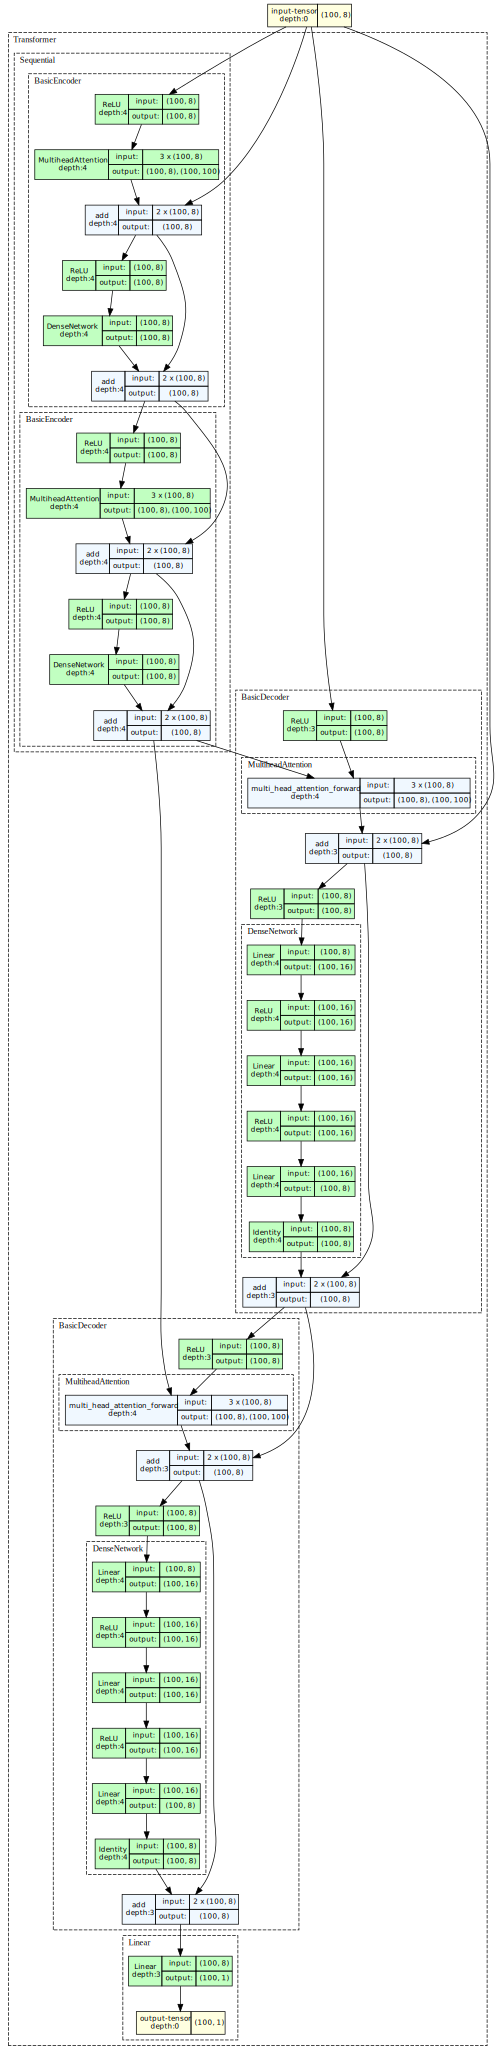

In [6]:
# Initialize the Transformer model and move it to the device
model = create_transformer(display_architecture=True)
model = model.to(device)

In [7]:
# PyTorch optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Loss function
def rmse_loss(y_true, y_pred):
    mse_loss = torch.nn.functional.mse_loss(y_pred, y_true) 
    return torch.sqrt(mse_loss)  
    
# loss_function =  torch.nn.MSELoss()  
loss_function = rmse_loss 

# Training

In [9]:
# hyperparameters
n_epochs = 1000
batch_size = 32
patience = 50
evaluattion_frequency_in_epochs = 10

In [10]:
# Dataloader with batches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_batches = len(train_loader)

In [11]:
# Training loop
best_dev_loss = float('inf') 
patience_counter = 0

for epoch in range(n_epochs):
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model.forward(X_batch)
        loss = loss_function(predictions, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Evaluate on dev set every 100 epochs
    if epoch % evaluattion_frequency_in_epochs == 0:
        with torch.no_grad():
            dev_predictions = model.forward(X_val_tensor)
            dev_loss = loss_function(dev_predictions, y_val_tensor).item()
        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {epoch_loss/num_batches:.6f}, Dev Loss: {dev_loss:.6f}")

    # Early stopping verification
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        patience_counter = 0  
        best_model_state = model.state_dict()  
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break    

Epoch 0/1000, Train Loss: 0.818161, Dev Loss: 0.743145
Epoch 10/1000, Train Loss: 0.443342, Dev Loss: 0.492097
Epoch 20/1000, Train Loss: 0.388789, Dev Loss: 0.470693
Epoch 30/1000, Train Loss: 0.367626, Dev Loss: 0.454813
Epoch 40/1000, Train Loss: 0.372382, Dev Loss: 0.447065
Epoch 50/1000, Train Loss: 0.353420, Dev Loss: 0.446066
Epoch 60/1000, Train Loss: 0.354871, Dev Loss: 0.432945
Epoch 70/1000, Train Loss: 0.364998, Dev Loss: 0.470543
Epoch 80/1000, Train Loss: 0.341015, Dev Loss: 0.457526
Epoch 90/1000, Train Loss: 0.347386, Dev Loss: 0.435736
Epoch 100/1000, Train Loss: 0.351480, Dev Loss: 0.435993
Epoch 110/1000, Train Loss: 0.345835, Dev Loss: 0.437810
Early stopping


In [12]:
# Evaluate on test data (explicitly passing input data)
with torch.no_grad():
    test_predictions = model.forward(X_test_tensor)
    test_loss = loss_function(test_predictions, y_test_tensor).item()
    print(f"Final Test Loss: {test_loss:.6f}")

Final Test Loss: 0.289729


In [13]:
# Save the model
torch.save(best_model_state, "critical_heat_flux_transformer.pth")

# Save scalers
joblib.dump(scaler_X, 'critical_heat_flux_transformer-scaler_X.pkl')
joblib.dump(scaler_y, 'critical_heat_flux_transformer-scaler_y.pkl')

['critical_heat_flux_transformer-scaler_y.pkl']